In [85]:
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.ndimage as ndi
import numpy as np

import PIL
from PIL import Image, ImageFilter
import time

import torch
import torch.nn as nn
import torch.optim

from skimage.measure import compare_psnr

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

factor = 4 # 8

In [74]:
class Concat(nn.Module):
    def __init__(self, dim, skip, deeper):
        super(Concat, self).__init__()
        self.dim = dim
        self.layer1 = skip
        self.layer2 = deeper
    def forward(self, input):
        inputs = []
        inputs.append(self.layer1(input))
        inputs.append(self.layer2(input))
        return torch.cat(inputs, dim=self.dim)

def get_name(name):
    name[0] +=1
    return str(name[0])

def skip(c_in, c_out, c_down, c_up, c_skip, k_down, k_up, k_skip, upsample_mode):
    model = nn.Sequential()
    model_tmp = model
    input_depth = c_in
    name = [0]
    for i in range(len(c_down)):
        layer = nn.Sequential()
        layer.add_module(get_name(name),nn.Conv2d(input_depth, c_down[i], k_down, 2, padding=int((k_down - 1) / 2)))
        layer.add_module(get_name(name),nn.BatchNorm2d(c_down[i]))
        layer.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))

        layer.add_module(get_name(name),nn.Conv2d(c_down[i], c_down[i], k_down, 1, padding=int((k_down - 1) / 2)))
        layer.add_module(get_name(name),nn.BatchNorm2d(c_down[i]))
        layer.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))

        deeper_main = nn.Sequential()
        
        if i < len(c_down)-1:
            layer.add_module(get_name(name),deeper_main)
            layer.add_module(get_name(name),nn.Upsample(scale_factor=2, mode=upsample_mode))
            if c_skip[i] != 0:
                concat_layers = []
                concat_layers.append(nn.Conv2d(input_depth, c_skip[i], k_skip, 1, padding=int((k_skip - 1) / 2)))
                concat_layers.append(nn.BatchNorm2d(c_skip[i]))
                concat_layers.append(nn.LeakyReLU(0.2, inplace=True))
                model_tmp.add_module(get_name(name),Concat(1, nn.Sequential(*concat_layers), layer))
            else:
                model_tmp.add_module(get_name(name),layer)
            model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_skip[i] + c_up[i + 1] ))
            model_tmp.add_module(get_name(name),nn.Conv2d(c_skip[i] + c_up[i + 1], c_up[i], k_up, 1, padding=int((k_up - 1) / 2)))
            
        else:#last layer
            layer.add_module(get_name(name),nn.Upsample(scale_factor=2, mode=upsample_mode))
            if c_skip[i] != 0:
                concat_layers = []
                concat_layers.append(nn.Conv2d(input_depth, c_skip[i], k_skip, 1, padding=int((k_skip - 1) / 2)))
                concat_layers.append(nn.BatchNorm2d(c_skip[i]))
                concat_layers.append(nn.LeakyReLU(0.2, inplace=True))
                model_tmp.add_module(get_name(name),Concat(1, nn.Sequential(*concat_layers), layer))
            else:
                model_tmp.add_module(get_name(name),layer)
            model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_skip[i] +c_down[i]))
            model_tmp.add_module(get_name(name),nn.Conv2d(c_skip[i] + c_down[i], c_up[i], k_up, 1, padding=int((k_up - 1) / 2)))

        model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_up[i]))
        model_tmp.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))
        model_tmp.add_module(get_name(name),nn.Conv2d(c_up[i], c_up[i], 1, 1))
        model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_up[i]))
        model_tmp.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))
        input_depth = c_down[i]
        model_tmp = deeper_main

    model.add_module(get_name(name),nn.Conv2d(c_up[0], c_out, 1, 1))
    model.add_module(get_name(name),nn.Sigmoid())

    return model

In [81]:
class Downsampler(nn.Module):
    def __init__(self, n_planes, factor, phase,preserve_size=True):
        super(Downsampler, self).__init__()

        k_size = 4*factor+1
        kernel_width = 4 * factor + 1
        kernel = np.zeros((4*factor, 4*factor))
        c = int((2*factor+1))
        ###################### 
        #Gaussian Kernel
        ######################
#         x = np.zeros((kernel_width-1, kernel_width-1))
#         c = int((kernel_width+1 ) / 2)
#         x[c][c] = 1
#         kernel = ndi.filters.gaussian_filter(x, sigma=16)
        ######################
        #Kernel used in Original Paper
        #####################
        for i in range(kernel.shape[0]):
            for j in range(kernel.shape[1]):
                if phase == 0.5:
                    di = abs(i+1+0.5-c) / factor  
                    dj = abs(j+1+0.5-c) / factor 
                else:
                    di = abs(i+1-center) / factor
                    dj = abs(j+1-center) / factor                
                pi_sq = np.pi * np.pi

                val = 1
                if di != 0:
                    val = val * 2 * np.sin(np.pi * di) * np.sin(np.pi * di / 2)
                    val = val / (np.pi * np.pi * di * di)
                
                if dj != 0:
                    val = val * 2 * np.sin(np.pi * dj) * np.sin(np.pi * dj / 2)
                    val = val / (np.pi * np.pi * dj * dj)
                kernel[i+1-1][j+1-1] = val
        ######################
        downsampler = nn.Conv2d(n_planes, n_planes, kernel_size=kernel.shape, stride=factor)
        downsampler.weight.data.fill_(0)#Need to set to zero, otherwise the color of imahe will be changed
        downsampler.bias.data.fill_(0)
        for i in range(n_planes):
            downsampler.weight.data[i, i] = torch.from_numpy(kernel/kernel.sum())       
        self.downsample_layer = downsampler
        if kernel.shape[0] % 2>0:
            self.padding_layer = nn.ConstantPad2d(int((kernel.shape[0] - 1) / 2.),0)
        if kernel.shape[0] % 2==0:
            self.padding_layer = nn.ConstantPad2d(int((kernel.shape[0] - factor) / 2.),0)
    def forward(self, x):
        x = self.padding_layer(x)
        x = self.downsample_layer(x)
        return x

In [113]:
def process_img(fname, factor):
    img = Image.open(fname)
    
    size = (img.size[0] - img.size[0] % 32, img.size[1] - img.size[1] % 32)

    bbox = [
            (img.size[0] - size[0])/2, 
            (img.size[1] - size[1])/2,
            (img.size[0] + size[0])/2,
            (img.size[1] + size[1])/2,
    ]

    img_HR = img.crop(bbox)
    
    LR_size = [img_HR.size[0] // factor, img_HR.size[1] // factor]
    img_LR = img_HR.resize(LR_size, Image.ANTIALIAS)
    
    img_np = np.array(img)/255
    img_HR_np = np.array(img_HR)/255
    img_LR_np = np.array(img_LR)/255

    if len(img_np.shape) == 3:
        img_np = img_np.transpose(2,0,1)
        img_HR_np = img_HR_np.transpose(2,0,1)
        img_LR_np = img_LR_np.transpose(2,0,1)
        plt.figure()
        plt.title("img_HR_np")
        plt.imshow(img_HR_np.transpose(1,2,0))
        plt.figure()
        plt.title("img_LR_np")
        plt.imshow(img_LR_np.transpose(1,2,0))
    else:
        img_np = img_np[None, ...]
        img_HR_np = img_HR_np[None, ...]
        img_LR_np = img_LR_np[None, ...]
        plt.figure()
        plt.title("img_HR_np")
        plt.imshow(img_HR_np[0])
        plt.figure()
        plt.title("img_LR_np")
        plt.imshow(img_LR_np[0])

    print('HR and LR resolutions: %s, %s' % (str(img_HR.size), str (img_LR.size)))

    return img_np, img_HR_np, img_LR_np, img_HR

HR and LR resolutions: (224, 320), (56, 80)


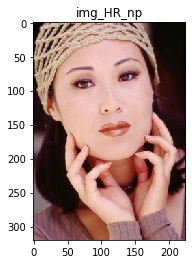

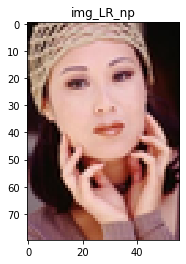

In [190]:
image_path = '/home/yujiaq3/ie534_project3/data/sr_dataset/Set5/woman.png'
img_np, img_HR_np, img_LR_np,img_HR = process_img(image_path, factor)

torch.Size([1, 32, 320, 224])
Op time: 3.709136
Iteration 00000  Loss 0.091349  PSNR LR 10.392984 HR 10.187876


/home/yujiaq3/venv_python3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


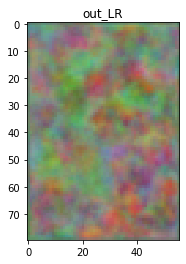

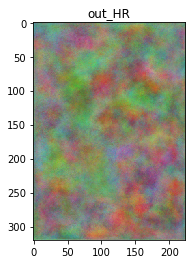

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 10.207026
Iteration 00100  Loss 0.004975  PSNR LR 23.032156 HR 21.048828


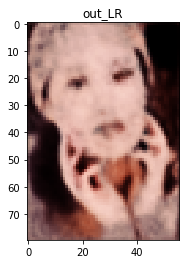

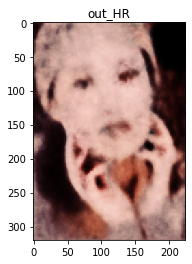

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 16.526132
Iteration 00200  Loss 0.002441  PSNR LR 26.124215 HR 22.975619


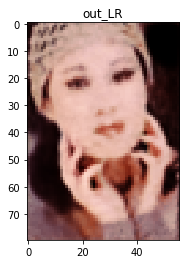

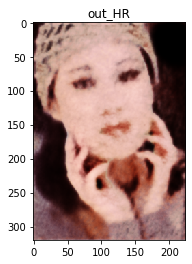

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 23.044921
Iteration 00300  Loss 0.001514  PSNR LR 28.200163 HR 24.018577


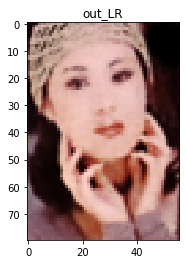

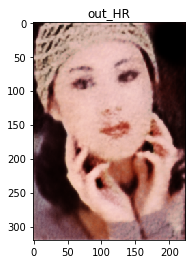

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 29.443563
Iteration 00400  Loss 0.001090  PSNR LR 29.625941 HR 24.616306


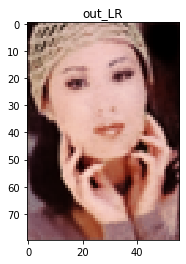

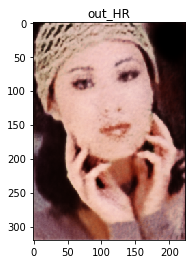

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 35.914963
Iteration 00500  Loss 0.000839  PSNR LR 30.764328 HR 25.026892


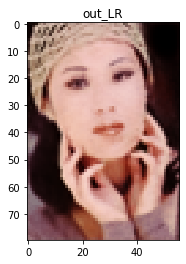

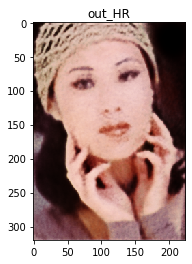

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 43.161989
Iteration 00600  Loss 0.000726  PSNR LR 31.391652 HR 25.215767


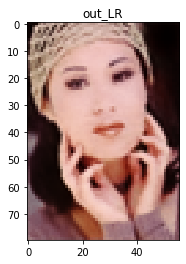

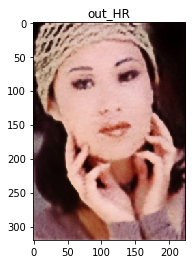

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 51.854155
Iteration 00700  Loss 0.000606  PSNR LR 32.178431 HR 25.624190


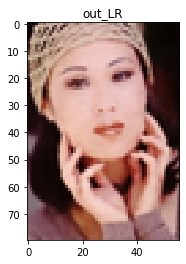

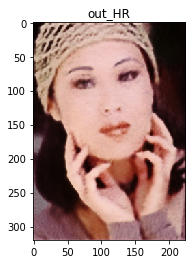

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 60.477992
Iteration 00800  Loss 0.000520  PSNR LR 32.841392 HR 25.696905


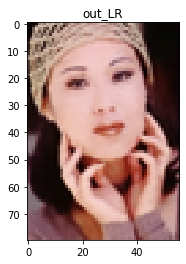

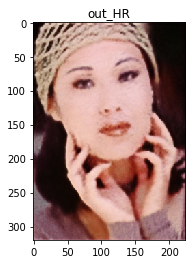

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 68.991016
Iteration 00900  Loss 0.000435  PSNR LR 33.615810 HR 25.929253


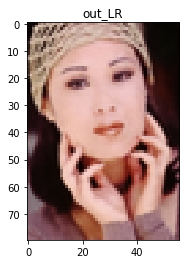

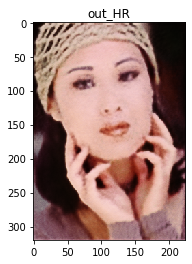

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 77.582774
Iteration 01000  Loss 0.000364  PSNR LR 34.384276 HR 26.050640


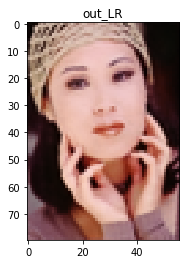

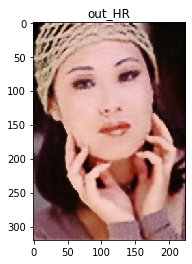

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 86.372730
Iteration 01100  Loss 0.000307  PSNR LR 35.124563 HR 26.175942


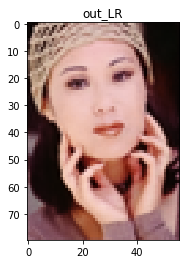

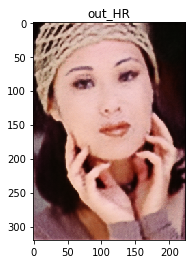

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 94.656868
Iteration 01200  Loss 0.000366  PSNR LR 34.365921 HR 26.145067


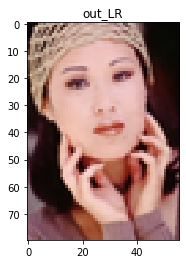

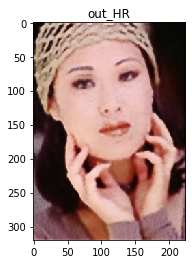

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 103.444824
Iteration 01300  Loss 0.000294  PSNR LR 35.319490 HR 26.237861


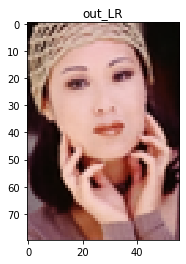

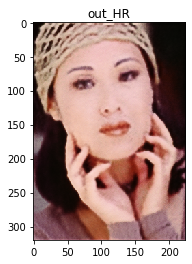

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 112.029138
Iteration 01400  Loss 0.000265  PSNR LR 35.762643 HR 26.293374


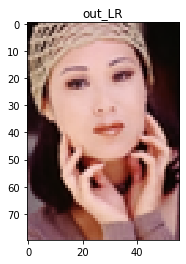

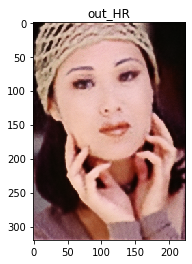

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 119.272107
Iteration 01500  Loss 0.000260  PSNR LR 35.849681 HR 26.350774


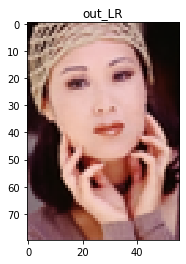

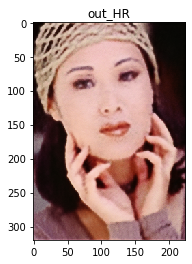

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 125.837259
Iteration 01600  Loss 0.000219  PSNR LR 36.591497 HR 26.542375


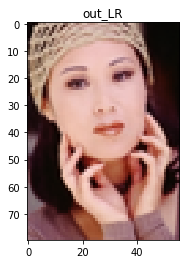

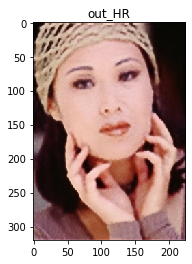

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 132.241204
Iteration 01700  Loss 0.000211  PSNR LR 36.755775 HR 26.557423


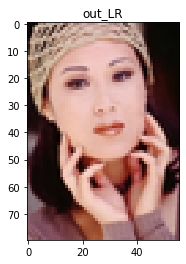

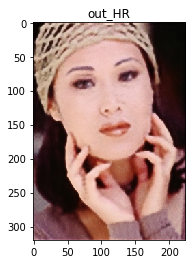

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 138.992141
Iteration 01800  Loss 0.000188  PSNR LR 37.255354 HR 26.603427


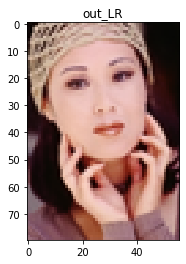

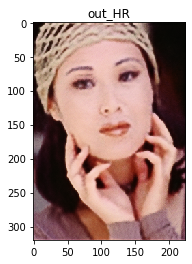

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Op time: 145.680825
Iteration 01900  Loss 0.000187  PSNR LR 37.283971 HR 26.603432


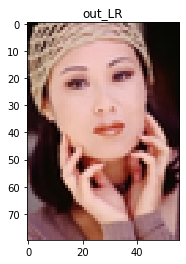

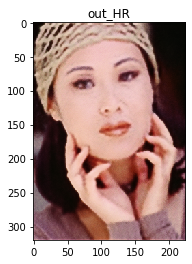

Op time: 151.909260


In [169]:
input_depth = 32
LR = 0.01 
if factor == 4: 
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05

if len(img_HR_np.shape)<3:
    c = 1
    w,h = img_HR_np.shape[0],img_HR_np.shape[1]
else:
    c = 3
    w,h = img_HR_np.shape[1], img_HR_np.shape[2]

model = skip(input_depth, c, 
               c_down = [128] * 5,
               c_up =   [128] * 5,
               c_skip =    [5] * 5,  
               k_up = 3, k_down = 3, 
               upsample_mode='bilinear', k_skip=1).type(dtype)

mse = torch.nn.MSELoss().type(dtype)

net_input = torch.zeros([1, input_depth, w, h])
print(net_input.shape)
net_input = net_input.type(dtype)
net_input.uniform_() #net_input.normal_()
net_input *= 0.1           
noise = net_input.detach().clone()
net_input_saved = net_input.detach().clone()

img_LR_torch = (torch.from_numpy(img_LR_np)[None, :]).type(dtype)
downsampler = Downsampler(3, factor, 0.5, True).type(dtype)
params = [x for x in model.parameters()]
optimizer = torch.optim.Adam(params, lr=LR)
PSNR = []
start = time.time()
for i in range(num_iter):
    optimizer.zero_grad()
    
    net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = model(net_input)
    out_LR = downsampler(out_HR)
    
    loss = mse(out_LR, img_LR_torch)
    
    loss.backward()
    
    optimizer.step()
    
    out_HR = out_HR.detach().cpu().numpy()[0]
    out_LR = out_LR.detach().cpu().numpy()[0]
#     print(img_LR_np.shape, out_LR.shape)
    PSNR.append([compare_psnr(img_LR_np, out_LR), compare_psnr(img_HR_np, out_HR)])

    if i % 100 == 0:
        print("Op time: %f" % (time.time()-start))
        print('Iteration %05d  Loss %f  PSNR LR %f HR %f' % (i, loss.item(), PSNR[-1][0],PSNR[-1][1]))
#         print(out_LR.shape, out_HR.shape)
        
        if len(img_np.shape)<3:
            plt.figure()
            plt.title("out_LR")
            plt.imshow(out_LR[0])
            plt.figure()
            plt.title("out_HR")
            plt.imshow(out_HR[0])
        else:
            plt.figure()
            plt.title("out_LR")
            plt.imshow(out_LR.transpose(1,2,0))
            plt.figure()
            plt.title("out_HR")
            plt.imshow(out_HR.transpose(1,2,0))
        plt.show()
print("Op time: %f" % (time.time()-start))

In [170]:
PSNR = [i[1] for i in PSNR]

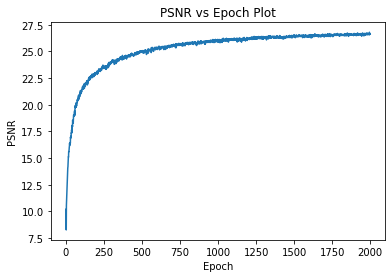

In [171]:
plt.title("PSNR vs Epoch Plot")
plt.xlabel("Epoch")
plt.ylabel("PSNR")
plt.plot(PSNR)

In [172]:
PSNR[-1]

26.622433893775657

In [145]:
set14 = [23.6248, 20.197, 24.20, 24.190, 24.55, 22.27,20.624, 27.010,27.724,23.71,28.098, 28.095, 28.02]


In [146]:
np.mean(np.array(set14))

24.791753846153842

In [147]:
(24.79-27.00)/27.00

-0.08185185185185188

In [186]:
Set5 = [24.79,28.59,26.778,28.098, 26.622]

In [187]:
np.mean(np.array(Set5))

26.975599999999996

In [189]:
(26.975-29.9)/29.90

-0.09782608695652165